# Rejection-Inversion for Log-Concave Distributions (RILC) Sampler for Hypergeometric Distribution

In [4]:
import time

import numpy as np
from scipy.special import gammaln
from scipy.optimize import root
from scipy.stats import linregress
import matplotlib.pyplot as plt

import mvhg

In [5]:
def get_log_pk(N, K, n, k):
    log_pk = (gammaln(K+1) - gammaln(k+1) - gammaln(K-k+1) +
              gammaln(N-K+1) - gammaln(n-k+1) - gammaln(N-K-n+k+1) -
              gammaln(N+1) + gammaln(n+1) + gammaln(N-n+1))
    return log_pk

def get_pk(N, K, n, k):
    return np.exp(get_log_pk(N, K, n, k))

In [6]:
N, K, n = 150, 100, 50
N, K, n = N, N - K, n
print(f"N = {N}, K = {K}, n = {n}")

N = 150, K = 50, n = 50


## Part 1: RILC Sampler Hat Function

In [7]:
km = np.floor((n+1) * (K+1) / (N+2)) + 1
ks = np.arange(max(0, n + K - N), min(K,n) + 1)
pks = np.array([get_pk(N, K, n, k) for k in ks])
log_pks = np.array([get_log_pk(N, K, n, k) for k in ks])
xs = np.linspace(ks[0], ks[-1], 500)
log_px = np.interp(xs, ks, log_pks)
px = np.exp(log_px)

In [8]:
px_fun = lambda x: np.exp(np.interp(x, ks, log_pks))
f = lambda x: px_fun(x + 1) / px_fun(x) - (1 + 1/(km - x))
x0 = km + 0.001
x0 = root(f, x0).x.item()

k0 = np.floor(x0 + 1)
log_pk0 = get_log_pk(N, K, n, k0)
log_pk1 = get_log_pk(N, K, n, k0-1)
pk0 = get_pk(N, K, n, k0)
b = log_pk0 - log_pk1
hx = pk0 * np.exp(b * (xs - k0))

print(f"x0 = {x0}, k0 = {np.floor(x0 + 1)}")

x0 = 20.360404723171204, k0 = 21.0


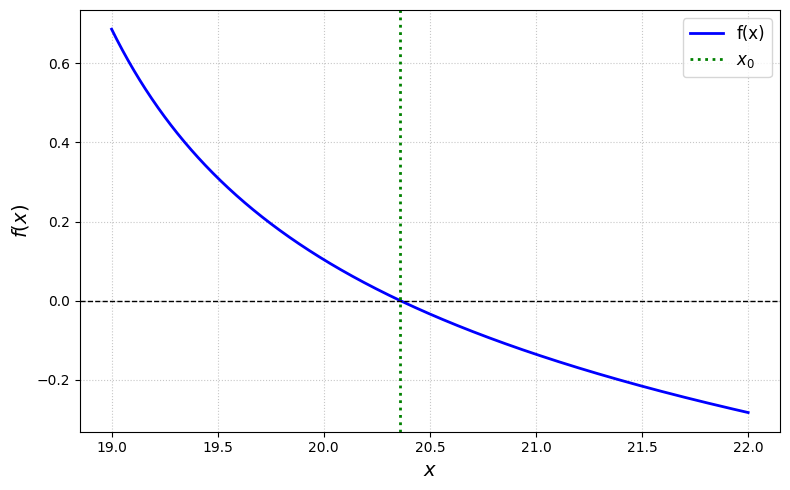

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))

xxs = np.linspace(k0 - 2, k0+1, 1000)
ax.plot(xxs, f(xxs), color='blue', linewidth=2, label='f(x)')
ax.axvline(x=x0, color='green', linestyle=':', linewidth=2, label=r'$x_0$')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$f(x)$', fontsize=14)

ax.grid(True, linestyle=':', alpha=0.7)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

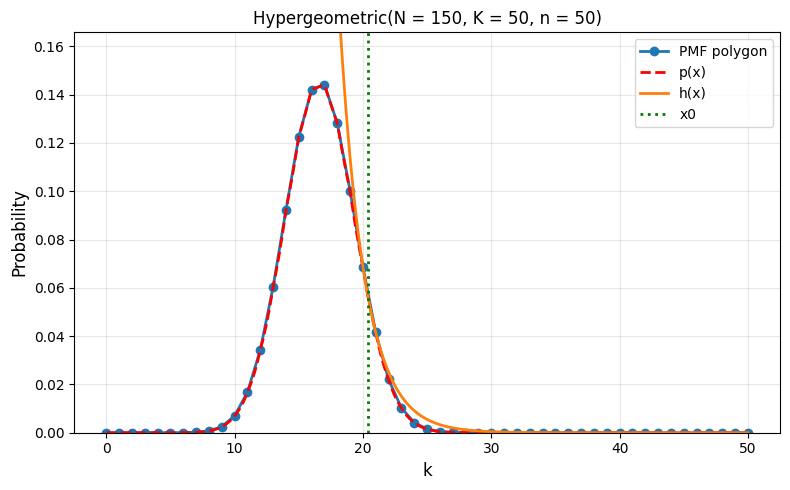

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ks, pks, 'o-', markersize=6, linewidth=2, label='PMF polygon')
ax.plot(xs, px, '--', color='red', linewidth=2, label='p(x)')
ax.plot(xs, hx, linewidth=2, label='h(x)')
ax.axvline(x=x0, color='green', linestyle=':', linewidth=2, label='x0')

ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.tick_params(axis='both', labelsize=10)
ax.legend(frameon=True, fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim(0, np.max(pks) * 1.15)
ax.set_title(f"Hypergeometric(N = {N}, K = {K}, n = {n})")

fig.tight_layout()
plt.show()

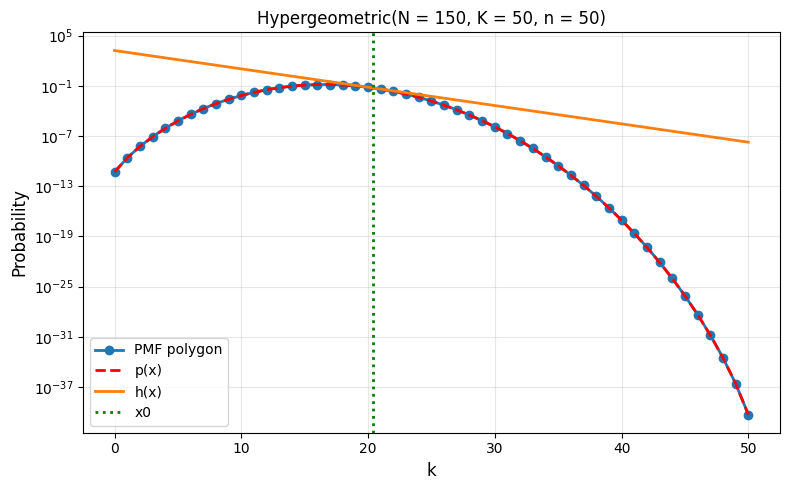

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ks, pks, 'o-', markersize=6, linewidth=2, label='PMF polygon')
ax.plot(xs, px, '--', color='red', linewidth=2, label='p(x)')
ax.plot(xs, hx, linewidth=2, label='h(x)')
ax.axvline(x=x0, color='green', linestyle=':', linewidth=2, label='x0')

ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.tick_params(axis='both', labelsize=10)
ax.legend(frameon=True, fontsize=10)
ax.grid(alpha=0.3)
ax.set_yscale('log')
ax.set_title(f"Hypergeometric(N = {N}, K = {K}, n = {n})")

fig.tight_layout()
plt.show()

## Part 2: RILC Sampler Empirical PMF

In [19]:
def plot_hist(N, K, n):
        num_samples = 1_000_000
        samples = mvhg.hypergeometric(N, K, n, num_samples)

        k_min = max(0, n + K - N)
        k_max = min(K, n)
        ks = np.arange(k_min, k_max + 1)

        pks = np.array([get_pk(N, K, n, k) for k in ks])

        fig, ax = plt.subplots(1, 2, figsize=(14,5))

        def _plot_hist(ax):
                ax.hist(samples, bins=np.arange(k_min - 0.5, k_max + 1.5, 1),
                        density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Samples')
                ax.plot(ks, pks, 'o-', color='red', linewidth=2, markersize=6, label='True PMF')

                ax.set_xlabel('k', fontsize=12)
                ax.set_ylabel('Probability', fontsize=12)
                ax.tick_params(axis='both', labelsize=10)
                ax.legend(fontsize=10)
                ax.grid(alpha=0.3)

        _plot_hist(ax[0])

        _plot_hist(ax[1])
        ax[1].set_yscale('log')

        fig.suptitle(f"Hypergeometric(N = {N}, K = {K}, n = {n})")
        fig.tight_layout()
        plt.show()

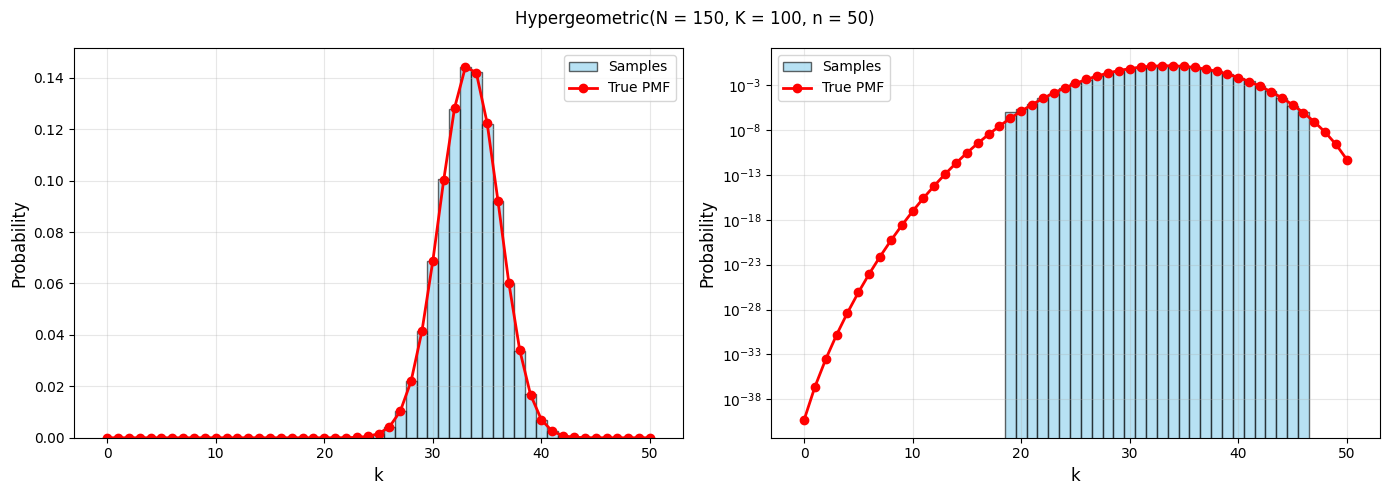

In [20]:
plot_hist(150, 100, 50)

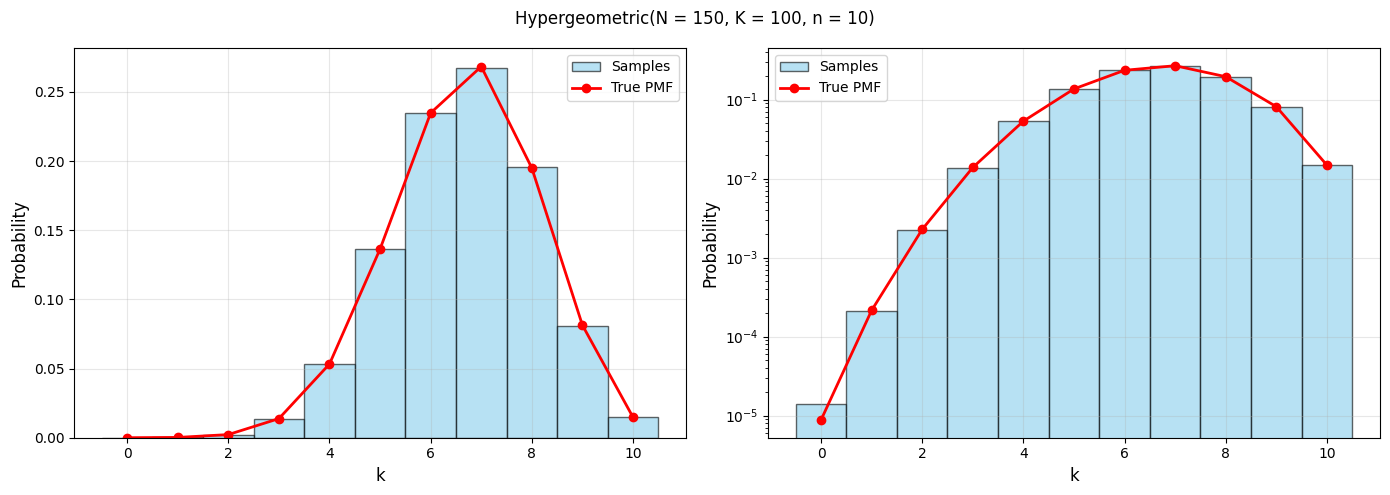

In [22]:
plot_hist(150, 100, 10)

## Part 3: Estimate Time Complexity

In [ ]:
sizes = np.logspace(2, 7, num=20, dtype=int)
M = 20
num_samples = 10_000

K_ratios = [0.01, 0.1, 0.5]
# K_ratios = [0.01]
n_ratio = 0.1

def time_sampler(N, K, n, num_samples, M):
    times = []
    for _ in range(M):
        start = time.time()
        _ = mvhg.hypergeometric(N, K, n, num_samples, num_max_iter = 10_000)
        times.append(time.time() - start)
    return np.mean(times)

results = {}
for ratio in K_ratios:
    times = []
    for N in sizes:
        K = int(ratio * N)
        n = int(n_ratio * N)
        if K > N or n > N:
            times.append(np.nan)
            continue
        t = time_sampler(N, K, n, num_samples, M)
        print(f"N={N:8d} K={K:6d} n={n:6d} t={t:6f}")
        times.append(t)
    results[ratio] = np.array(times)

N=     100 K=     1 n=    10 t=0.034307
N=     183 K=     1 n=    18 t=0.031956
N=     335 K=     3 n=    33 t=0.034766
N=     615 K=     6 n=    61 t=0.035349
N=    1128 K=    11 n=   112 t=0.035963
N=    2069 K=    20 n=   206 t=0.035813
N=    3792 K=    37 n=   379 t=0.037214
N=    6951 K=    69 n=   695 t=0.037126
N=   12742 K=   127 n=  1274 t=0.038449
N=   23357 K=   233 n=  2335 t=0.041481
N=   42813 K=   428 n=  4281 t=0.050673
N=   78475 K=   784 n=  7847 t=0.059299
N=  143844 K=  1438 n= 14384 t=0.075091
N=  263665 K=  2636 n= 26366 t=0.099002
N=  483293 K=  4832 n= 48329 t=0.149775
N=  885866 K=  8858 n= 88586 t=0.244439
N= 1623776 K= 16237 n=162377 t=0.387513
N= 2976351 K= 29763 n=297635 t=0.795410
N= 5455594 K= 54555 n=545559 t=2.126978
N=10000000 K=100000 n=1000000 t=4.817936
N=     100 K=    10 n=    10 t=0.032948
N=     183 K=    18 n=    18 t=0.033691
N=     335 K=    33 n=    33 t=0.034237
N=     615 K=    61 n=    61 t=0.035121
N=    1128 K=   112 n=   112 t=0.035829

K/N=0.010: empirical complexity ≈ O(n^1.35)
K/N=0.100: empirical complexity ≈ O(n^1.17)
K/N=0.500: empirical complexity ≈ O(n^1.14)


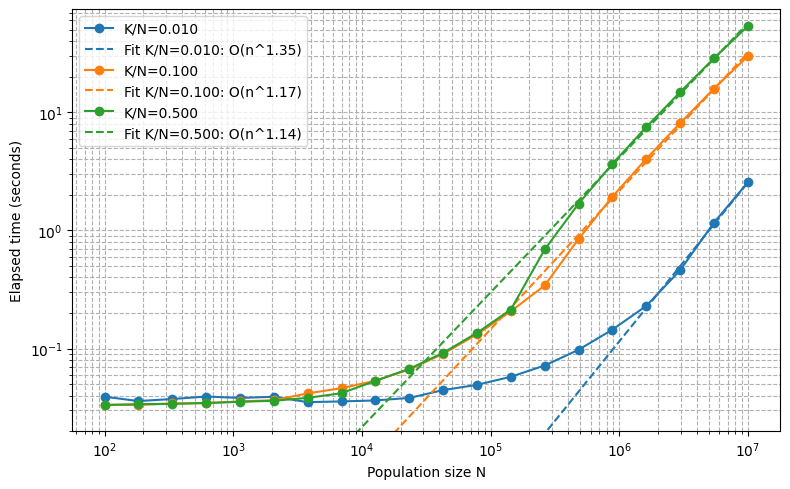

In [ ]:
burn_in = {}
burn_in[0.01] = 16
burn_in[0.1] = 14
burn_in[0.5] = 14

fig, ax = plt.subplots(figsize=(8, 5))

for ratio, times in results.items():
    sizes_fit = sizes[burn_in[ratio]:]
    means_fit = times[burn_in[ratio]:]
    log_sizes = np.log10(sizes_fit)
    log_means = np.log10(means_fit)
    slope, intercept, _, _, _ = linregress(log_sizes, log_means)
    fit_times = 10**(intercept + slope * np.log10(sizes))
    ax.loglog(sizes, times, "o-", label=f"K/N={ratio:.3f}")
    ax.loglog(sizes, fit_times, "--", color=ax.lines[-1].get_color(),
              label=f"Fit K/N={ratio:.3f}: O(n^{slope:.2f})")
    print(f"K/N={ratio:.3f}: empirical complexity ≈ O(n^{slope:.2f})")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Population size N")
ax.set_ylabel("Elapsed time (seconds)")
ax.legend()
ax.grid(True, which="both", ls="--")

ax.set_ylim([2e-2, 0.75e2])

plt.tight_layout()
plt.show()